In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-02-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-02-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-03-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-02-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-05-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_0

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import glob
import soundfile
import os
import sys
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [48]:
from IPython.display import Audio

In [103]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [49]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Data preparation

In [50]:
RavdessData = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"


In [51]:
ravdessDirectoryList = os.listdir(RavdessData)
fileEmotion = []
filePath = []
for dir in ravdessDirectoryList:
    actor = os.listdir(RavdessData + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        fileEmotion.append(int(part[2]))
        filePath.append(RavdessData + dir + '/' + file)
emotion_df = pd.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pd.DataFrame(filePath, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


In [52]:
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprised'},inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprised  /kaggle/input/ravdess-emotional-speech-audio/a...
1    neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2    disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3    disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4    neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

In [53]:
datapath = pd.concat([Ravdess_df], axis = 0)
datapath.to_csv("data_path_csv", index=False)
datapath.head()

Emotions                                               Path
0  surprised  /kaggle/input/ravdess-emotional-speech-audio/a...
1    neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2    disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3    disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4    neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

    Data Visualisation

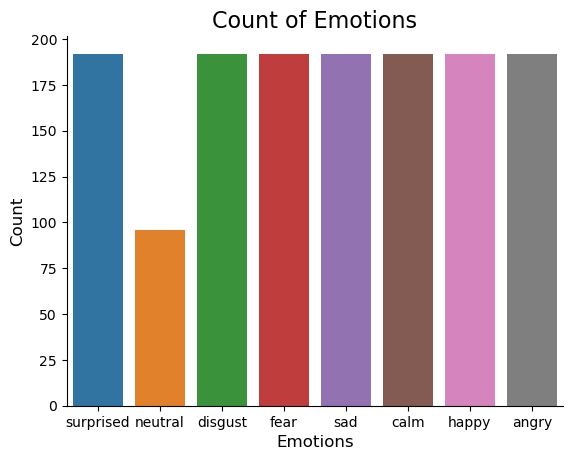

In [54]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=datapath['Emotions'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [55]:
def Waveplot(data, sr, emotion):
    plt.figure(figsize=(10,3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [56]:
def Spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12,3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time',y_axis='hz')
    plt.colorbar()    


In [57]:
def Wave_Spect(emotion):
    path = np.array(datapath.Path[datapath.Emotions==emotion])[0]
    data, sampling_rate = librosa.load(path)
    Waveplot(data, sampling_rate, emotion)
    Spectrogram(data, sampling_rate, emotion)
    return str(path)

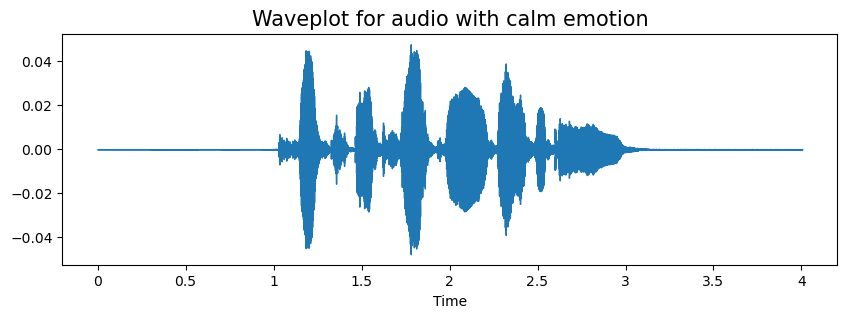

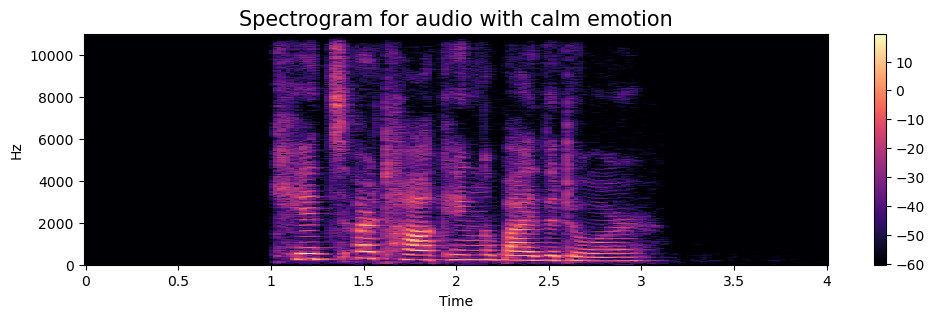

In [58]:
Audio(Wave_Spect('calm'))

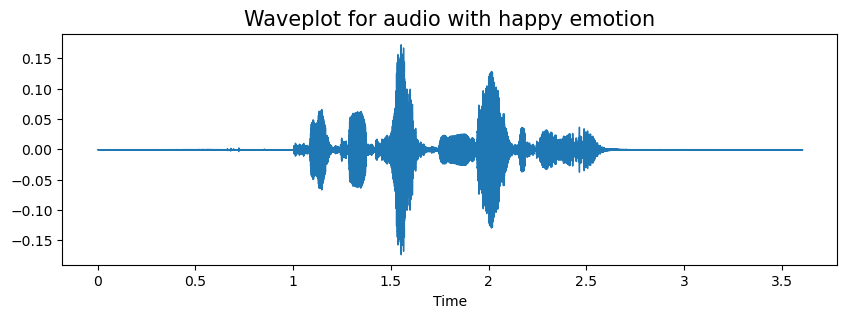

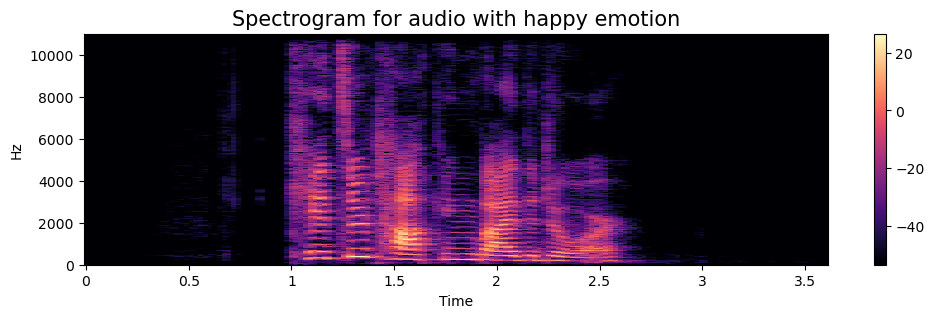

In [59]:
Audio(Wave_Spect('happy'))

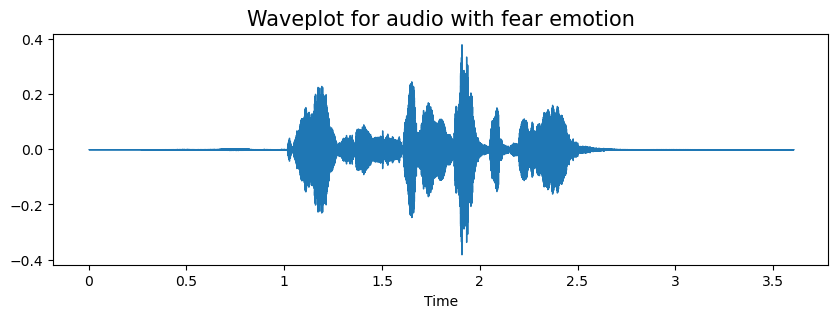

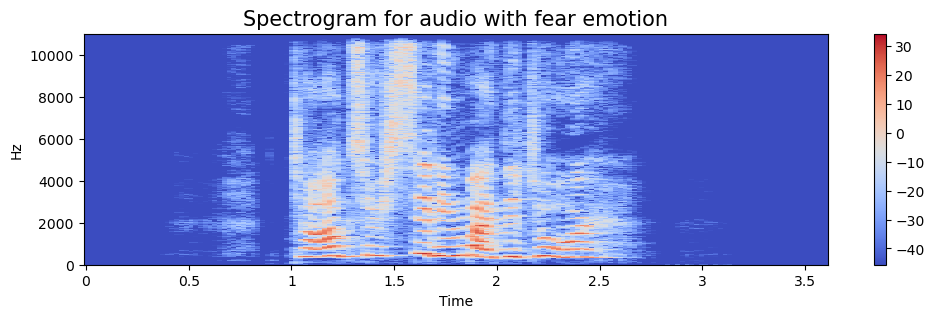

In [60]:
Audio(Wave_Spect('fear'))

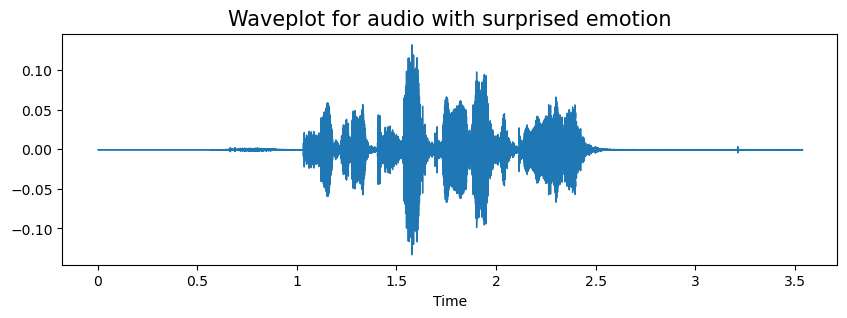

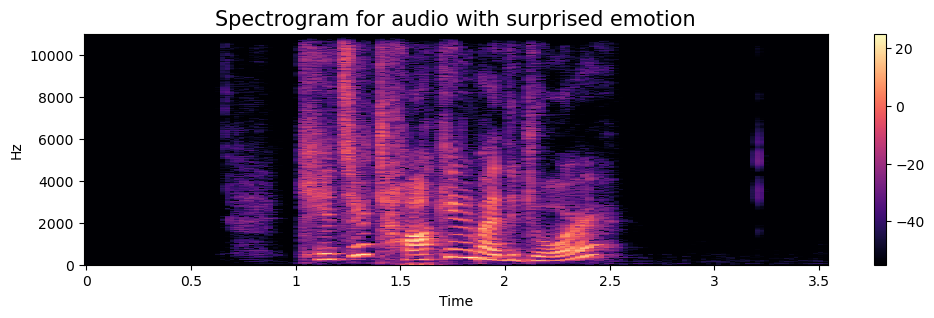

In [61]:
Audio(Wave_Spect('surprised'))

Data Augmentation

In [78]:
def noise(data):
    noiseAmp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noiseAmp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shiftRange = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shiftRange)

def pitch(data, sampleRate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampleRate, n_steps=pitch_factor)



In [63]:
#pitch_shift_range = 0.5
#pitch_shift_value = np.random.uniform(-pitch_shift_range, pitch_shift_range)

#noise_level_range = (0.001, 0.004)
#noise_level = np.random.uniform(*noise_level_range)

#time_stretch_range = (0.9, 1.1)
#time_stretch_factor = np.random.uniform(*time_stretch_range)

In [64]:
path = np.array(datapath.Path)[1]
data, sampleRate = librosa.load(path)

1. Simple Audio

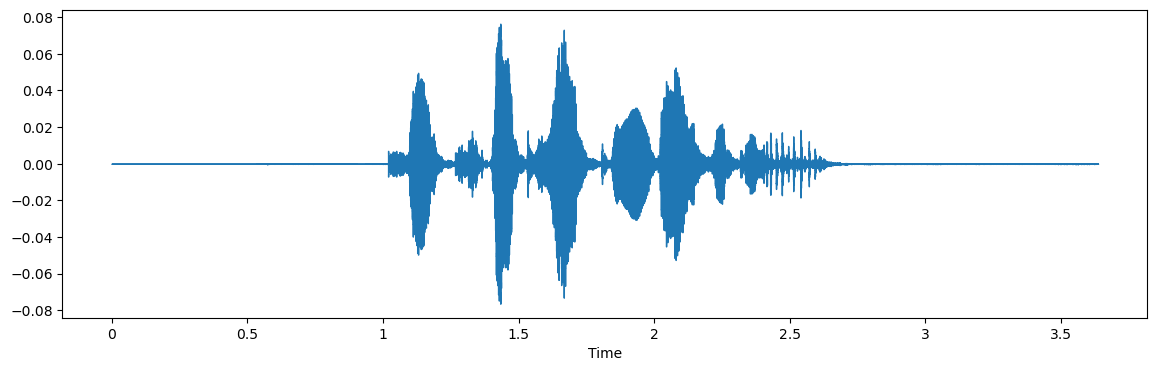

In [65]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sampleRate)
Audio(path)

2. Noise Injection

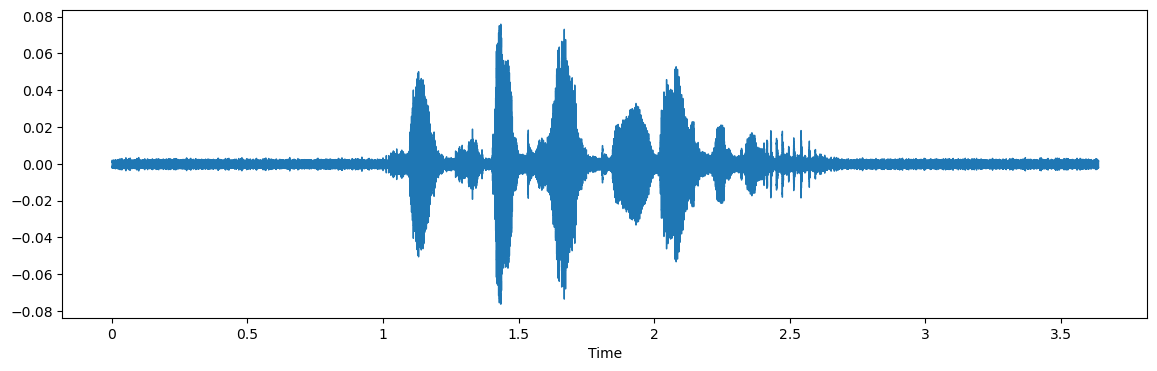

In [66]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

3. Stretching

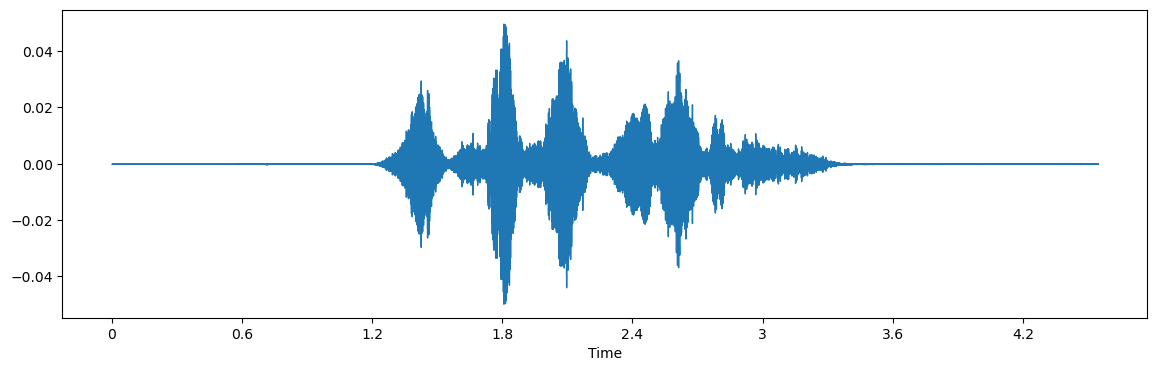

In [67]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

4. Shifting

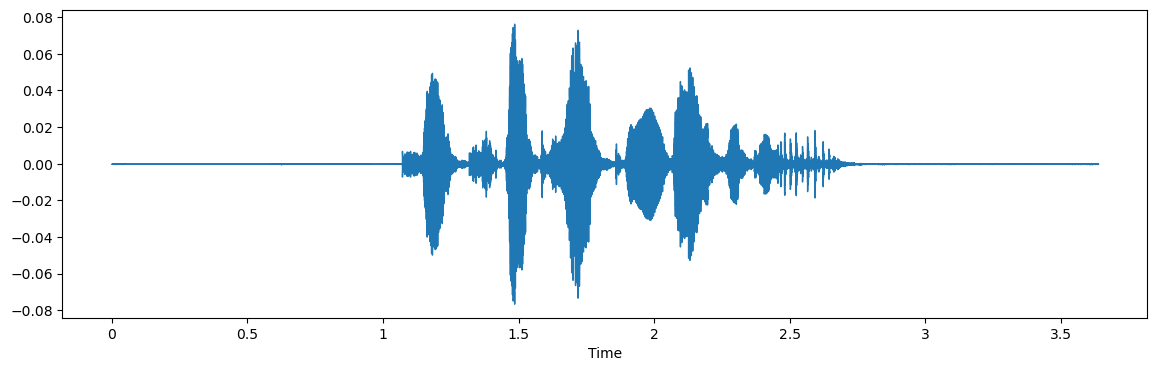

In [68]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

5. Pitch

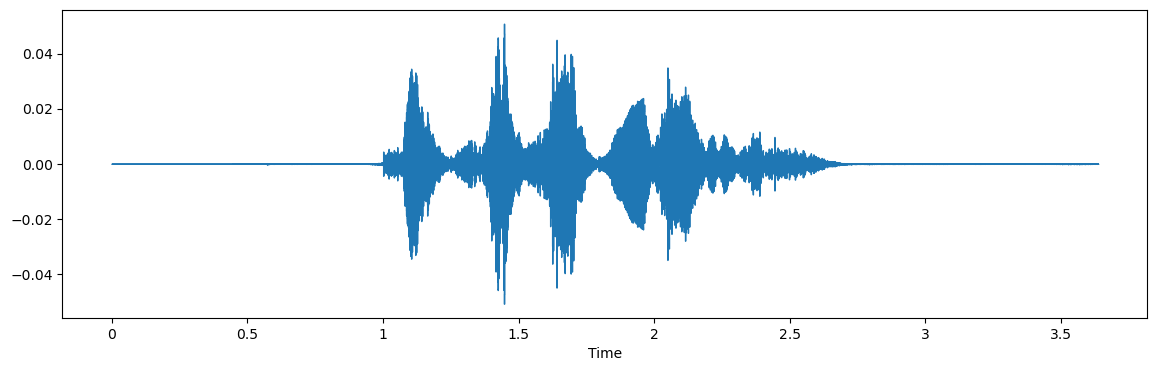

In [79]:
x = pitch(data, sampleRate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

Feature Extraction

In [80]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampleRate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
       # MelSpectogram
        
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampleRate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sampleRate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sampleRate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [81]:
X, Y = [], []
for path, emotion in zip(datapath.Path, datapath.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [82]:
len(X), len(Y), datapath.Path.shape

(4320, 4320, (1440,))

In [91]:
len(Y)

69120

In [83]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.237382  0.682273  0.670519  0.614793  0.579039  0.566803  0.637206   
1  0.322229  0.723291  0.727446  0.721472  0.709065  0.703062  0.728969   
2  0.185641  0.701612  0.669995  0.646503  0.569480  0.522185  0.620173   
3  0.256113  0.621621  0.580278  0.598515  0.628296  0.598015  0.597272   
4  0.307893  0.692254  0.681765  0.718592  0.753431  0.713059  0.653822   

          7         8         9  ...       152       153       154       155  \
0  0.667451  0.663883  0.669903  ...  0.000234  0.000235  0.000138  0.000128   
1  0.714453  0.701023  0.689973  ...  0.001028  0.000986  0.000843  0.000848   
2  0.694168  0.706139  0.679075  ...  0.000047  0.000049  0.000054  0.000048   
3  0.650352  0.698636  0.681863  ...  0.000018  0.000016  0.000013  0.000012   
4  0.676903  0.725084  0.714078  ...  0.000149  0.000153  0.000150  0.000142   

        156       157       158       159           160     labels  
0  0.000299  0.000360  0.000275  0.000173  2.896729e-05  surprised  
1  0.001024  0.001037  0.001017  0.000896  7.269923e-04  surprised  
2  0.000024  0.000053  0.000074  0.000031  2.444069e-06  surprised  
3  0.000007  0.000008  0.000008  0.000005  5.802853e-07    neutral  
4  0.000139  0.000146  0.000141  0.000135  1.349379e-04    neutral  

[5 rows x 162 columns]

Data Preparation

In [94]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [95]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [96]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 161), (3240, 8), (1080, 161), (1080, 8))

In [97]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 161), (3240, 8), (1080, 161), (1080, 8))

In [98]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 161, 1), (3240, 8), (1080, 161, 1), (1080, 8))

Modelling

In [104]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 161, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)         

In [105]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 10s 179ms/step - loss: 1.9916 - accuracy: 0.1932 - val_loss: 1.9648 - val_accuracy: 0.2324 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 9s 172ms/step - loss: 1.9417 - accuracy: 0.2293 - val_loss: 1.8607 - val_accuracy: 0.2713 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 9s 175ms/step - loss: 1.8483 - accuracy: 0.2762 - val_loss: 1.8069 - val_accuracy: 0.2935 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 9s 173ms/step - loss: 1.7990 - accuracy: 0.3059 - val_loss: 1.7173 - val_accuracy: 0.3296 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 9s 174ms/step - loss: 1.7449 - accuracy: 0.3275 - val_loss: 1.6937 - val_accuracy: 0.3426 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 9s 173ms/step - loss: 1.7003 - accuracy: 0.3568 - val_loss: 1.6338 - val_accuracy: 0.3657 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 9s 176ms/step - l

34/34 [==============================] - 1s 19ms/step - loss: 1.3563 - accuracy: 0.6676
Accuracy of our model on test data :  66.75925850868225 %


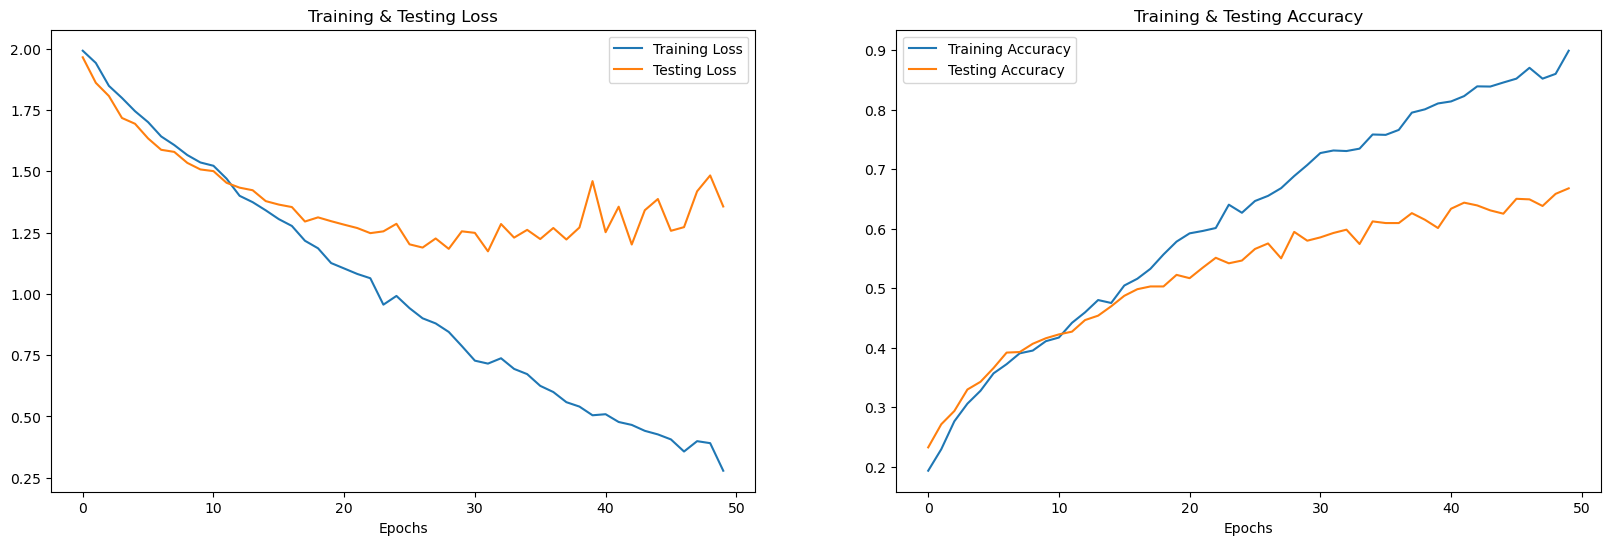

In [106]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [107]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 18ms/step


In [108]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1          neutral       neutral
2          disgust           sad
3            happy       neutral
4             fear          fear
5            angry         angry
6             fear          fear
7             fear          fear
8          disgust       disgust
9             calm          calm

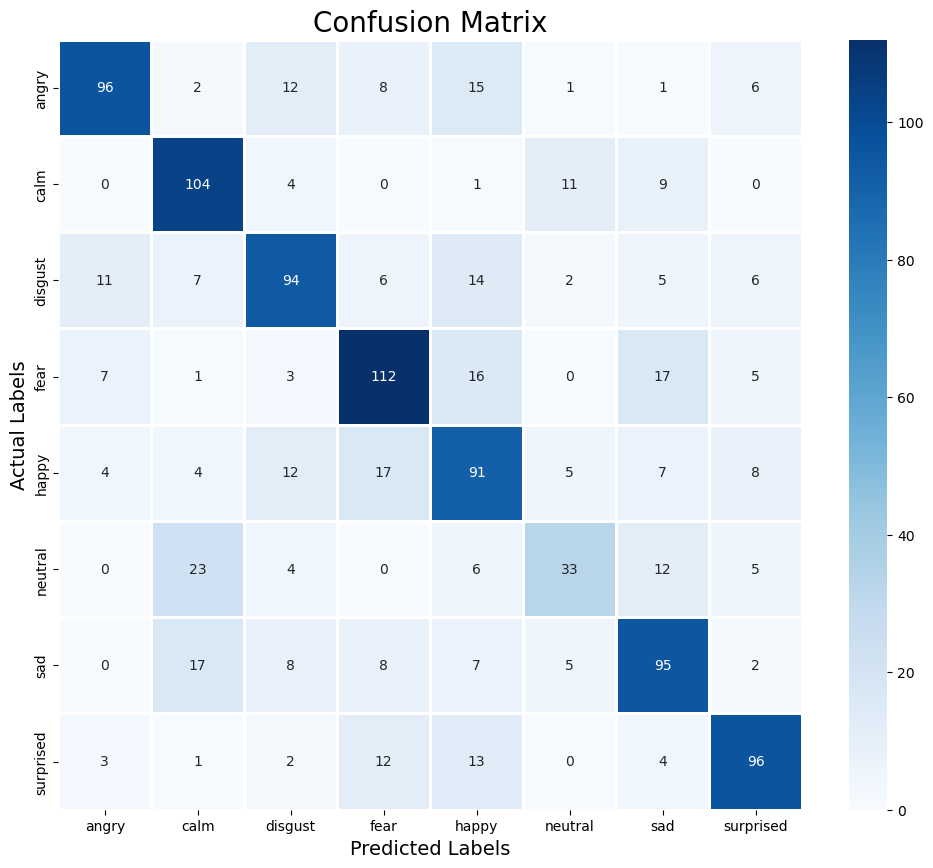

In [109]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.68      0.73       141
        calm       0.65      0.81      0.72       129
     disgust       0.68      0.65      0.66       145
        fear       0.69      0.70      0.69       161
       happy       0.56      0.61      0.59       148
     neutral       0.58      0.40      0.47        83
         sad       0.63      0.67      0.65       142
   surprised       0.75      0.73      0.74       131

    accuracy                           0.67      1080
   macro avg       0.67      0.66      0.66      1080
weighted avg       0.67      0.67      0.67      1080

